In [1]:
import rlssm
import pandas as pd
import os

/Users/Khamir/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Import the data of a single subject

In [2]:
par_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(par_path, 'data/data_experiment.csv')

data = pd.read_csv(data_path, index_col=0)

data = data[data.participant == 20].reset_index(drop=True)

data['block_label'] += 1

data.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,20,1.0,1.0,46.0,46.0,4,2,1.0,2.574407,1.0
1,20,1.0,2.0,60.0,33.0,4,2,2.0,1.952774,1.0
2,20,1.0,3.0,32.0,44.0,2,1,2.0,2.074999,0.0
3,20,1.0,4.0,56.0,40.0,4,2,3.5,2.320916,0.0
4,20,1.0,5.0,34.0,32.0,2,1,3.5,1.471107,1.0


#### Initialise the model

In [3]:
model = rlssm.RLModel_2A(hierarchical_levels = 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_229abb1bf4586a669e33ca0e37a3f1a6 NOW.


In [4]:
model.family, model.model_label, model.hierarchical_levels

('RL_2A', 'RL_2A', 1)

In [5]:
model.increasing_sensitivity, model.separate_learning_rates

(False, False)

#### Fit

In [6]:
# sampling parameters
n_iter = 1000
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options
initial_value_learning = 27.5 # intitial value (Q0)

# bayesian model
alpha_pos_priors = {'mu':0, 'sd':1}

In [7]:
model_fit = model.fit(
    data, 
    K, 
    initial_value_learning,
    alpha_pos_priors = alpha_pos_priors,
    thin = n_thin,
    iter = n_iter,
    chains = n_chains,
    verbose = False)

Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
0.0 of 1000 iterations ended with a divergence (0.0%)
0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [8]:
model_fit.to_pickle()

Saving file as: /Users/Khamir/DecisionMaking/_Reports/_7/rlssm/notebooks/RL_2A.pkl


#### get Rhat

In [9]:
model_fit.rhat.describe()

,rhat
count,2.000000
mean,1.002109
std,0.001624
min,1.000960
25%,1.001535
50%,1.002109
75%,1.002683
max,1.003257


In [10]:
model_fit.rhat.head()

,rhat,variable
0,1.000960,alpha
1,1.003257,sensitivity


#### get wAIC

In [11]:
model_fit.waic

{'lppd': -76.97013061057595,
 'p_waic': 1.7340252693723337,
 'waic': 157.40831175989658,
 'waic_se': 16.213903729323565}

### Posteriors

In [12]:
model_fit.samples

,chain,draw,transf_alpha,transf_sensitivity
0,0,95,0.252922,0.337992
1,0,496,0.137568,0.387734
2,0,47,0.150139,0.373766
3,0,198,0.115881,0.391605
4,0,322,0.074116,0.420454
...,...,...,...,...
995,1,51,0.017141,0.981319
996,1,68,0.211227,0.374542
997,1,222,0.144698,0.377223
998,1,169,0.166888,0.356034


In [13]:
model_fit.trial_samples

OrderedDict([('log_p_t',
              array([[-0.69314718, -0.69314718, -0.17540653, ..., -0.26507785,
                      -0.44263214, -0.00868956],
                     [-0.69314718, -0.69314718, -0.27642889, ..., -0.23897815,
                      -0.33199082, -0.00448024],
                     [-0.69314718, -0.69314718, -0.26538817, ..., -0.24940579,
                      -0.35227896, -0.00540284],
                     ...,
                     [-0.69314718, -0.69314718, -0.27175908, ..., -0.24680515,
                      -0.34532976, -0.00516252],
                     [-0.69314718, -0.69314718, -0.25358637, ..., -0.26250141,
                      -0.37778395, -0.00687862],
                     [-0.69314718, -0.69314718, -0.34079495, ..., -0.27990627,
                      -0.35929725, -0.00958352]]))])

In [14]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

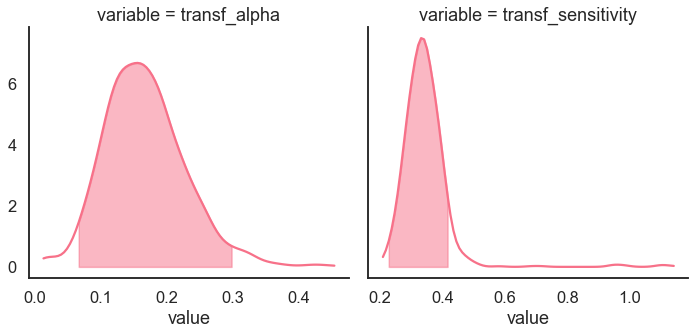

In [15]:
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

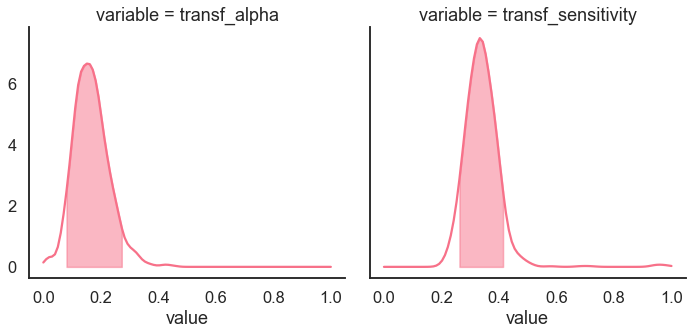

In [16]:
model_fit.plot_posteriors(height=5, show_intervals="BCI", alpha_intervals=.1, clip=(0, 1));

### Posterior predictives

#### Ungrouped

In [17]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=500)

pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 231 232 233 234   
sample                                                 ...                   
1               0   0   1   1   1   1   1   1   0   1  ...   0   0   1   1   
2               1   0   0   1   1   1   0   0   0   1  ...   0   1   1   1   
3               1   1   1   1   1   0   1   1   0   1  ...   1   1   1   1   
4               1   1   0   1   1   0   0   1   0   1  ...   1   0   1   1   
5               0   0   1   0   0   1   1   1   0   1  ...   0   1   1   0   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
496             0   0   0   1   0   1   0   1   0   1  ...   0   0   1   1   
497             1   1   1   1   1   1   1   0   0   1  ...   1   1   1   1   
498             1   0   0   1   0   0   0   1   0   1  ...   1   1   1   0   
499             0   1   1   1   0   0   1   0   0   0  ...   1   0   1   1   
500             1   1   1   0   1   1   1   1   0   0  ...   0   1   1   1   

variable                          
trial    235 236 237 238 239 240  
sample                            
1          1   1   1   1   1   1  
2          1   0   1   0   1   1  
3          1   1   1   1   0   1  
4          1   0   1   1   1   1  
5          1   0   1   1   1   1  
...       ..  ..  ..  ..  ..  ..  
496        1   0   1   1   0   1  
497        1   1   1   1   0   1  
498        1   1   1   1   0   1  
499        1   1   1   1   1   1  
500        1   0   1   1   1   1  

[500 rows x 240 columns]

In [18]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=500)

pp_summary

,mean_accuracy
sample,
1,0.812500
2,0.875000
3,0.850000
4,0.858333
5,0.875000
...,...
496,0.866667
497,0.854167
498,0.845833


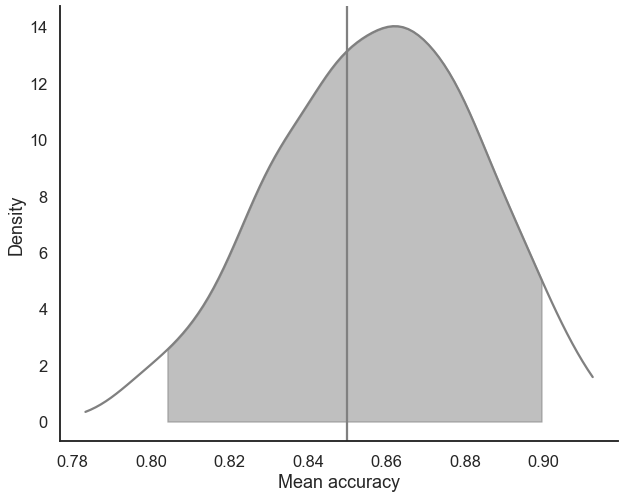

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

#### Grouped

In [20]:
import numpy as np

data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

data.head()

,index,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,choice_pair,block_bins
0,0,20,1.0,1.0,46.0,46.0,4,2,1.0,2.574407,1.0,BD,1
1,1,20,1.0,2.0,60.0,33.0,4,2,2.0,1.952774,1.0,BD,1
2,2,20,1.0,3.0,32.0,44.0,2,1,2.0,2.074999,0.0,AB,1
3,3,20,1.0,4.0,56.0,40.0,4,2,3.5,2.320916,0.0,BD,1
4,4,20,1.0,5.0,34.0,32.0,2,1,3.5,1.471107,1.0,AB,1


In [21]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1.0         1          AB          1            0.800000
                                   2            0.800000
                                   3            0.800000
                                   4            0.800000
                                   5            0.400000
...                                                  ...
3.0         8          CD          496          0.666667
                                   497          1.000000
                                   498          1.000000
                                   499          1.000000
                                   500          1.000000

[46000 rows x 1 columns]

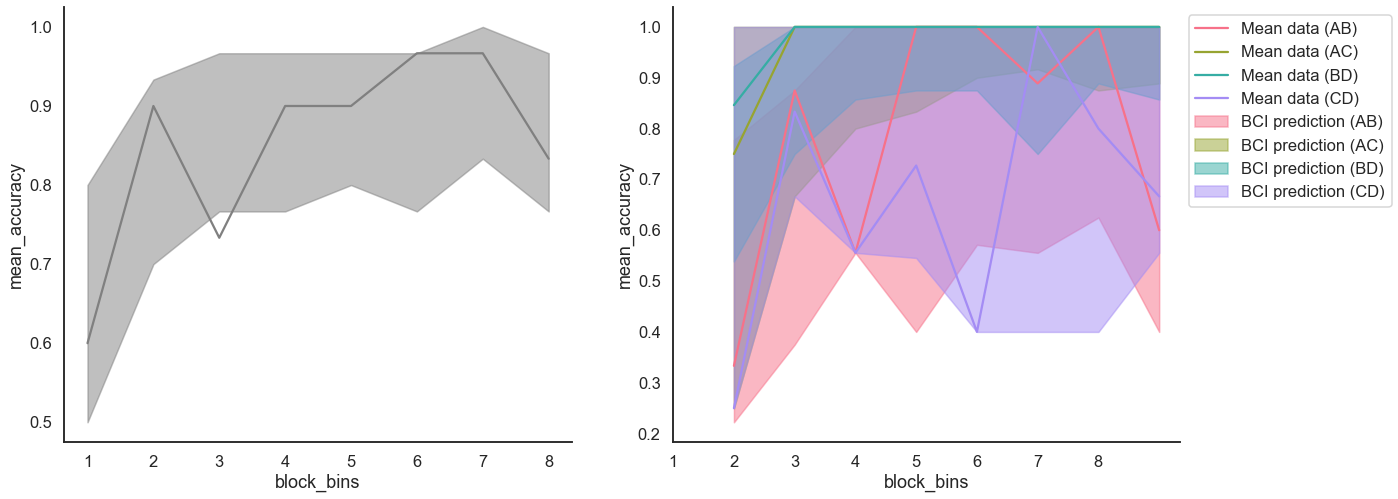

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()

### Get last values for eventual further sampling

In [23]:
sv = model_fit.last_values
sv

,chain,draw,warmup,alpha,sensitivity
499,0,499,0,-0.834771,-0.905776
999,1,499,0,-0.785360,-0.946677
